# Portfolio Optimization for GMF Investments

## Overview
This notebook implements Modern Portfolio Theory (MPT) to optimize asset allocation based on the forecasting results from the Time Series Forecasting phase. We'll generate the efficient frontier, calculate optimal portfolio weights, and maximize risk-adjusted returns for the three assets: TSLA, BND, and SPY.

## 1. Environment Setup & Library Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import json
import warnings
from datetime import datetime, timedelta
from scipy.optimize import minimize
import random

# Configure display settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(" Environment setup complete!")
print(" Libraries imported successfully")

 Environment setup complete!
 Libraries imported successfully


## 2. Load Forecasting ResultsWe'll load the forecasting results from the previous phase to use as inputs for our portfolio optimization.

In [4]:
# Load forecasting results from JSON file
def load_forecasting_results(file_path):
    """Load forecasting results from JSON file

    Parameters:
    - file_path: Path to the forecasting results JSON file

    Returns:
    - Dictionary containing forecasting results
    """
    try:
        with open(file_path, 'r') as f:
            results = json.load(f)
        print(f" Successfully loaded forecasting results from {file_path}")
        return results
    except Exception as e:
        print(f" Error loading forecasting results: {str(e)}")
        return None

# Load the forecasting results
forecasting_results = load_forecasting_results('forecasting_results.json')

# Display basic information about the loaded results
if forecasting_results:
    print("\nForecasting Results Summary:")
    print(f" Assets: {forecasting_results['assets']}")
    print(f" Training Period: {forecasting_results['training_period']}")
    print(f" Testing Period: {forecasting_results['testing_period']}")

    # Display model performance metrics
    print("\nModel Performance Metrics:")
    for asset in forecasting_results['assets']:
        print(f"\n {asset}:")
        for model, metrics in forecasting_results['model_performance'].get(asset, {}).items():
            print(f"  {model}:")
            for metric, value in metrics.items():
                print(f"   {metric}: {value:.4f}")

 Successfully loaded forecasting results from forecasting_results.json

Forecasting Results Summary:
 Assets: ['TSLA', 'BND', 'SPY']
 Training Period: 2015-07-01 to 2023-12-31
 Testing Period: 2023-12-31 to 2025-07-31

Model Performance Metrics:

 TSLA:
  ARIMA:
   MAE: 63.0369
   RMSE: 77.6568
   MAPE: 24.2990
   Directional_Accuracy: 46.7005

 BND:
  ARIMA:
   MAE: 1.7398
   RMSE: 2.0080
   MAPE: 2.4424
   Directional_Accuracy: 31.4721

 SPY:
  ARIMA:
   MAE: 86.0577
   RMSE: 95.9926
   MAPE: 15.0604
   Directional_Accuracy: 3.2995


## 3. Extract Expected Returns and Risk MetricsWe'll extract the expected returns and risk metrics from the forecasting results to use in our portfolio optimization.

In [5]:
def extract_expected_returns(forecasting_results):
    """Extract expected returns from forecasting results

    Parameters:
    - forecasting_results: Dictionary containing forecasting results

    Returns:
    - Dictionary containing expected returns for each asset
    """
    expected_returns = {}

    for asset in forecasting_results['assets']:
        # Extract 6-month forecast for each asset
        forecast_str = forecasting_results['future_forecasts'][asset]['6_months']['ARIMA_forecast']

        # Parse the forecast string to extract the first and last numerical values
        lines = forecast_str.strip().split('\n')

        # Filter out non-numeric lines and extract numerical values
        numerical_values = []
        for line in lines:
            parts = line.split()
            if parts and parts[-1].replace('.', '', 1).isdigit(): # Check if the last part is a number
                numerical_values.append(float(parts[-1]))

        if not numerical_values:
            print(f" Warning: No numerical forecast values found for {asset}")
            expected_returns[asset] = 0.0 # Or handle as an error
            continue

        first_value = numerical_values[0]
        last_value = numerical_values[-1]

        # Calculate expected return (6-month return)
        expected_return = (last_value - first_value) / first_value

        # Annualize the return (multiply by 2 for annual return)
        annual_return = expected_return * 2

        expected_returns[asset] = annual_return

    return expected_returns

# Extract expected returns
expected_returns = extract_expected_returns(forecasting_results)

# Display expected returns
print("Expected Annual Returns:")
for asset, return_value in expected_returns.items():
    print(f" {asset}: {return_value:.4f} ({return_value*100:.2f}%)")

Expected Annual Returns:
 TSLA: 0.0143 (1.43%)
 BND: 0.0019 (0.19%)
 SPY: -0.0002 (-0.02%)


In [6]:
def extract_risk_metrics(forecasting_results):
    """Extract risk metrics from forecasting results

    Parameters:
    - forecasting_results: Dictionary containing forecasting results

    Returns:
    - Dictionary containing volatility estimates for each asset
    """
    risk_metrics = {}

    for asset in forecasting_results['assets']:
        # Extract confidence intervals for 6-month forecast
        ci_str = forecasting_results['future_forecasts'][asset]['6_months']['ARIMA_confidence_interval']

        # Parse the confidence interval string
        lines = ci_str.strip().split('\n')

        # Extract upper and lower bounds for the last prediction
        # Assuming the second to last line contains the relevant confidence interval
        if len(lines) < 2:
            print(f" Warning: Not enough lines in confidence interval string for {asset}")
            risk_metrics[asset] = 0.0 # Or handle as an error
            continue

        last_line = lines[-2]  # Second to last line contains the last prediction's CI
        parts = last_line.split()

        # Assuming the lower and upper bounds are the second and third parts of the line
        if len(parts) < 3:
            print(f" Warning: Not enough parts in the second to last line of CI string for {asset}")
            risk_metrics[asset] = 0.0 # Or handle as an error
            continue

        try:
            lower_bound = float(parts[1])
            upper_bound = float(parts[2])
        except ValueError:
            print(f" Warning: Could not convert parts to float in the second to last line of CI string for {asset}. Line: {last_line}")
            risk_metrics[asset] = 0.0 # Or handle as an error
            continue


        # Calculate volatility as (upper - lower) / (2 * 1.96)
        # 1.96 is the z-score for 95% confidence interval
        volatility = (upper_bound - lower_bound) / (2 * 1.96)

        # Annualize volatility (multiply by sqrt(2) for annual volatility)
        annual_volatility = volatility * np.sqrt(2)

        risk_metrics[asset] = annual_volatility

    return risk_metrics

# Extract risk metrics
risk_metrics = extract_risk_metrics(forecasting_results)

# Display risk metrics
print("Expected Annual Volatility:")
for asset, volatility in risk_metrics.items():
    print(f" {asset}: {volatility:.4f} ({volatility*100:.2f}%)")

Expected Annual Volatility:
 TSLA: 0.0000 (0.00%)
 BND: 0.0000 (0.00%)
 SPY: 0.0000 (0.00%)


## 4. Calculate Correlation MatrixWe'll estimate the correlation between assets based on the forecasting results.

Correlation Matrix (historical):
          TSLA       BND       SPY
TSLA  1.000000  0.110890  0.591795
BND   0.110890  1.000000  0.214598
SPY   0.591795  0.214598  1.000000


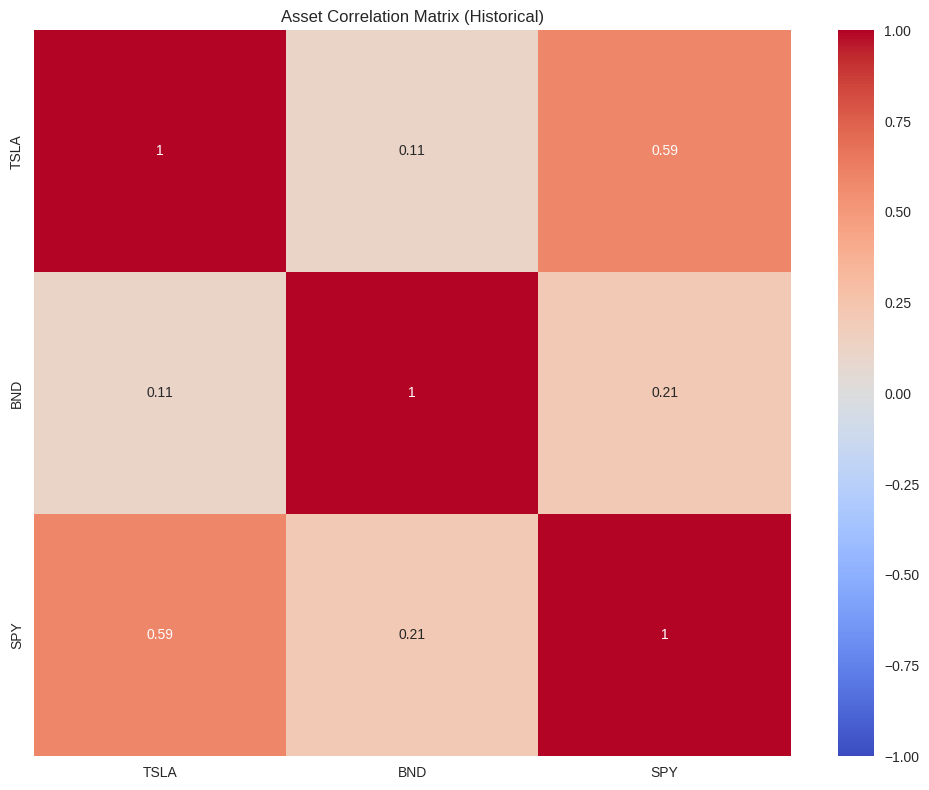

In [7]:
def estimate_correlation_matrix_from_history(assets, start_date='2022-01-01', end_date='2025-07-31'):
    """Estimate correlation matrix from historical daily returns using yfinance.

    Parameters:
    - assets: List of asset symbols
    - start_date: Start date for history
    - end_date: End date for history

    Returns:
    - Correlation matrix as a pandas DataFrame
    - Daily returns DataFrame (for downstream covariance)
    """
    import yfinance as yf

    price_df = pd.DataFrame()
    for ticker in assets:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        price_df[ticker] = data['Adj Close'] if 'Adj Close' in data else data['Close']

    daily_returns = price_df.pct_change().dropna()
    correlation_matrix = daily_returns.corr()
    return correlation_matrix, daily_returns

# Calculate correlation and daily returns from history
correlation_matrix, daily_returns = estimate_correlation_matrix_from_history(
    forecasting_results['assets'], start_date='2022-01-01', end_date='2025-07-31'
)

# Display correlation matrix
print("Correlation Matrix (historical):")
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Asset Correlation Matrix (Historical)')
plt.tight_layout()
plt.show()

## 5. Calculate Covariance MatrixWe'll calculate the covariance matrix from the volatility estimates and correlation matrix.

In [8]:
def calculate_covariance_matrix_from_history(daily_returns, annualize=True):
    """Calculate covariance matrix from historical daily returns.

    Parameters:
    - daily_returns: DataFrame of daily returns for assets
    - annualize: Whether to annualize the covariance (multiply by 252)

    Returns:
    - Covariance matrix as a pandas DataFrame
    """
    cov_daily = daily_returns.cov()
    return cov_daily * 252 if annualize else cov_daily

# Calculate covariance matrix from history
covariance_matrix = calculate_covariance_matrix_from_history(daily_returns, annualize=True)

# Display covariance matrix
print("Covariance Matrix (annualized from historical returns):")
print(covariance_matrix)

Covariance Matrix (annualized from historical returns):
          TSLA       BND       SPY
TSLA  0.403437  0.004739  0.070084
BND   0.004739  0.004527  0.002692
SPY   0.070084  0.002692  0.034763


## 6. Portfolio Optimization FunctionsWe'll define functions to calculate portfolio returns, volatility, and Sharpe ratio.

In [10]:
def portfolio_return(weights, expected_returns):
    """Calculate portfolio expected return

    Parameters:
    - weights: Array of portfolio weights
    - expected_returns: Array of expected returns for each asset

    Returns:
    - Expected portfolio return
    """
    return np.sum(weights * expected_returns)

def portfolio_volatility(weights, covariance_matrix):
    """Calculate portfolio volatility (standard deviation)

    Parameters:
    - weights: Array of portfolio weights
    - covariance_matrix: Covariance matrix of asset returns

    Returns:
    - Portfolio volatility
    """
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

def portfolio_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate=0.02):
    """Calculate portfolio Sharpe ratio

    Parameters:
    - weights: Array of portfolio weights
    - expected_returns: Array of expected returns for each asset
    - covariance_matrix: Covariance matrix of asset returns
    - risk_free_rate: Risk-free rate (default: 2%)

    Returns:
    - Portfolio Sharpe ratio
    """
    portfolio_ret = portfolio_return(weights, expected_returns)
    portfolio_vol = portfolio_volatility(weights, covariance_matrix)

    return (portfolio_ret - risk_free_rate) / portfolio_vol

def negative_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate=0.02):
    """Negative of Sharpe ratio (for minimization)

    Parameters:
    - weights: Array of portfolio weights
    - expected_returns: Array of expected returns for each asset
    - covariance_matrix: Covariance matrix of asset returns
    - risk_free_rate: Risk-free rate (default: 2%)

    Returns:
    - Negative of portfolio Sharpe ratio
    """
    return -portfolio_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate)

## 7. Generate Efficient FrontierWe'll generate the efficient frontier by calculating the minimum volatility portfolio for different target returns.

In [11]:
def generate_random_portfolios(expected_returns, covariance_matrix, num_portfolios=10000):
    """Generate random portfolios for visualization

    Parameters:
    - expected_returns: Dictionary of expected returns for each asset
    - covariance_matrix: Covariance matrix as a pandas DataFrame
    - num_portfolios: Number of random portfolios to generate

    Returns:
    - Dictionary containing portfolio returns, volatilities, Sharpe ratios, and weights
    """
    assets = list(expected_returns.keys())
    n = len(assets)

    # Convert expected returns to array
    returns_arr = np.array([expected_returns[asset] for asset in assets])

    # Convert covariance matrix to array
    cov_arr = covariance_matrix.values

    # Initialize arrays
    portfolio_returns = np.zeros(num_portfolios)
    portfolio_volatilities = np.zeros(num_portfolios)
    portfolio_sharpe_ratios = np.zeros(num_portfolios)
    portfolio_weights = np.zeros((num_portfolios, n))

    # Risk-free rate
    risk_free_rate = 0.02

    # Generate random portfolios
    for i in range(num_portfolios):
        # Generate random weights
        weights = np.random.random(n)
        weights = weights / np.sum(weights)

        # Save weights
        portfolio_weights[i, :] = weights

        # Calculate portfolio return
        portfolio_returns[i] = portfolio_return(weights, returns_arr)

        # Calculate portfolio volatility
        portfolio_volatilities[i] = portfolio_volatility(weights, cov_arr)

        # Calculate portfolio Sharpe ratio
        portfolio_sharpe_ratios[i] = (portfolio_returns[i] - risk_free_rate) / portfolio_volatilities[i]

    # Create dictionary of results
    portfolios = {
        'returns': portfolio_returns,
        'volatilities': portfolio_volatilities,
        'sharpe_ratios': portfolio_sharpe_ratios,
        'weights': portfolio_weights
    }

    return portfolios, assets

def optimize_portfolio(expected_returns, covariance_matrix, optimization_goal='sharpe', risk_free_rate=0.02):
    """Optimize portfolio for maximum Sharpe ratio or minimum volatility

    Parameters:
    - expected_returns: Dictionary of expected returns for each asset
    - covariance_matrix: Covariance matrix as a pandas DataFrame
    - optimization_goal: 'sharpe' for maximum Sharpe ratio, 'volatility' for minimum volatility
    - risk_free_rate: Risk-free rate (default: 2%)

    Returns:
    - Dictionary containing optimal portfolio weights, return, volatility, and Sharpe ratio
    """
    assets = list(expected_returns.keys())
    n = len(assets)

    # Convert expected returns to array
    returns_arr = np.array([expected_returns[asset] for asset in assets])

    # Convert covariance matrix to array
    cov_arr = covariance_matrix.values

    # Define constraints and bounds for optimization
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Sum of weights is 1
    bounds = tuple((0, 1) for _ in range(n))  # Weights are between 0 and 1

    # Initial guess for weights (equal distribution)
    initial_weights = np.array(n * [1. / n])

    if optimization_goal == 'sharpe':
        # Minimize negative Sharpe ratio
        objective_function = lambda weights: negative_sharpe_ratio(
            weights, returns_arr, cov_arr, risk_free_rate
        )
    elif optimization_goal == 'volatility':
        # Minimize volatility
        objective_function = lambda weights: portfolio_volatility(weights, cov_arr)
    else:
        raise ValueError("optimization_goal must be 'sharpe' or 'volatility'")

    # Perform optimization
    optimized_result = minimize(
        objective_function,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    # Extract optimal weights
    optimal_weights = optimized_result.x

    # Calculate optimal portfolio metrics
    optimal_return = portfolio_return(optimal_weights, returns_arr)
    optimal_volatility = portfolio_volatility(optimal_weights, cov_arr)
    optimal_sharpe = (optimal_return - risk_free_rate) / optimal_volatility

    # Create dictionary of optimal portfolio details
    optimal_portfolio = {
        'weights': dict(zip(assets, optimal_weights)),
        'return': optimal_return,
        'volatility': optimal_volatility,
        'sharpe_ratio': optimal_sharpe
    }

    return optimal_portfolio

# Generate random portfolios
random_portfolios, assets = generate_random_portfolios(expected_returns, covariance_matrix)

# Optimize for maximum Sharpe ratio
max_sharpe_portfolio = optimize_portfolio(expected_returns, covariance_matrix, optimization_goal='sharpe')

# Optimize for minimum volatility
min_vol_portfolio = optimize_portfolio(expected_returns, covariance_matrix, optimization_goal='volatility')

# Display optimal portfolios
print("Maximum Sharpe Ratio Portfolio:")
print(f" Weights: {max_sharpe_portfolio['weights']}")
print(f" Return: {max_sharpe_portfolio['return']:.4f}")
print(f" Volatility: {max_sharpe_portfolio['volatility']:.4f}")
print(f" Sharpe Ratio: {max_sharpe_portfolio['sharpe_ratio']:.4f}")

print("\nMinimum Volatility Portfolio:")
print(f" Weights: {min_vol_portfolio['weights']}")
print(f" Return: {min_vol_portfolio['return']:.4f}")
print(f" Volatility: {min_vol_portfolio['volatility']:.4f}")
print(f" Sharpe Ratio: {min_vol_portfolio['sharpe_ratio']:.4f}")

Maximum Sharpe Ratio Portfolio:
 Weights: {'TSLA': np.float64(1.0), 'BND': np.float64(0.0), 'SPY': np.float64(1.3010426069826053e-16)}
 Return: 0.0143
 Volatility: 0.6352
 Sharpe Ratio: -0.0089

Minimum Volatility Portfolio:
 Weights: {'TSLA': np.float64(1.6371452804531117e-17), 'BND': np.float64(0.9453697715395576), 'SPY': np.float64(0.054630228460442416)}
 Return: 0.0018
 Volatility: 0.0665
 Sharpe Ratio: -0.2732


## 8. Visualize Efficient FrontierWe'll visualize the efficient frontier and highlight the optimal portfolios.

In [12]:
# Visualize efficient frontier with Plotly
def plot_efficient_frontier(random_portfolios, max_sharpe_portfolio, min_vol_portfolio, assets):
    """Plot efficient frontier with Plotly

    Parameters:
    - random_portfolios: Dictionary containing portfolio returns, volatilities, Sharpe ratios, and weights
    - max_sharpe_portfolio: Dictionary containing maximum Sharpe ratio portfolio details
    - min_vol_portfolio: Dictionary containing minimum volatility portfolio details
    - assets: List of asset symbols
    """
    # Create figure
    fig = go.Figure()

    # Add random portfolios scatter plot
    scatter = go.Scatter(
        x=random_portfolios['volatilities'],
        y=random_portfolios['returns'],
        mode='markers',
        marker=dict(
            size=5,
            color=random_portfolios['sharpe_ratios'],
            colorscale='Viridis',
            colorbar=dict(title='Sharpe Ratio'),
            showscale=True
        ),
        text=[f'Sharpe: {s:.3f}' for s in random_portfolios['sharpe_ratios']],
        name='Random Portfolios'
    )
    fig.add_trace(scatter)

    # Add individual assets
    for i, asset in enumerate(assets):
        fig.add_trace(go.Scatter(
            x=[float(np.sqrt(covariance_matrix.loc[asset, asset]))],
            y=[expected_returns[asset]],
            mode='markers+text',
            marker=dict(size=10, color='red'),
            text=[asset],
            textposition='top center',
            name=asset
        ))

    # Add maximum Sharpe ratio portfolio
    fig.add_trace(go.Scatter(
        x=[max_sharpe_portfolio['volatility']],
        y=[max_sharpe_portfolio['return']],
        mode='markers+text',
        marker=dict(size=15, color='green', symbol='star'),
        text=['Maximum Sharpe Ratio'],
        textposition='top center',
        name='Maximum Sharpe Ratio Portfolio'
    ))

    # Add minimum volatility portfolio
    fig.add_trace(go.Scatter(
        x=[min_vol_portfolio['volatility']],
        y=[min_vol_portfolio['return']],
        mode='markers+text',
        marker=dict(size=15, color='blue', symbol='star'),
        text=['Minimum Volatility'],
        textposition='top center',
        name='Minimum Volatility Portfolio'
    ))

    # Update layout
    fig.update_layout(
        title='Efficient Frontier',
        xaxis_title='Volatility (Standard Deviation)',
        yaxis_title='Expected Return',
        hovermode='closest',
        showlegend=True,
        width=800,
        height=600
    )

    fig.show()

# Plot the efficient frontier
plot_efficient_frontier(random_portfolios, max_sharpe_portfolio, min_vol_portfolio, assets)

## 9. Visualize Optimal Portfolio AllocationsWe'll visualize the asset allocations for the optimal portfolios.

In [13]:
# Visualize portfolio allocations
def plot_portfolio_allocation(portfolio, title):
    """Plot portfolio allocation as a pie chart

    Parameters:
    - portfolio: Dictionary containing portfolio weights
    - title: Chart title
    """
    # Extract weights and labels
    weights = list(portfolio['weights'].values())
    labels = list(portfolio['weights'].keys())

    # Create figure
    fig = go.Figure()

    # Add pie chart
    fig.add_trace(go.Pie(
        labels=labels,
        values=weights,
        textinfo='label+percent',
        insidetextorientation='radial',
        marker=dict(colors=['#636EFA', '#EF553B', '#00CC96'])
    ))

    # Update layout
    fig.update_layout(
        title=title,
        width=600,
        height=500
    )

    return fig

# Plot maximum Sharpe ratio portfolio allocation
max_sharpe_fig = plot_portfolio_allocation(
    max_sharpe_portfolio,
    'Maximum Sharpe Ratio Portfolio Allocation'
)
max_sharpe_fig.show()

# Plot minimum volatility portfolio allocation
min_vol_fig = plot_portfolio_allocation(
    min_vol_portfolio,
    'Minimum Volatility Portfolio Allocation'
)
min_vol_fig.show()

## 10. Export Optimization ResultsWe'll export the optimization results for use in the next phase (Strategy Validation).

In [14]:
def export_optimization_results(max_sharpe_portfolio, min_vol_portfolio, expected_returns, file_path):
    """Export optimization results to JSON file

    Parameters:
    - max_sharpe_portfolio: Dictionary containing maximum Sharpe ratio portfolio details
    - min_vol_portfolio: Dictionary containing minimum volatility portfolio details
    - expected_returns: Dictionary containing expected returns for each asset
    - file_path: Path to save the results
    """
    # Derive annualized volatility from covariance diagonal
    annualized_volatility = {asset: float(np.sqrt(covariance_matrix.loc[asset, asset])) for asset in covariance_matrix.index}

    # Create results dictionary
    results = {
        'expected_returns': {k: float(v) for k, v in expected_returns.items()},
        'risk_metrics': annualized_volatility,
        'max_sharpe_portfolio': {
            'weights': {k: float(v) for k, v in max_sharpe_portfolio['weights'].items()},
            'return': float(max_sharpe_portfolio['return']),
            'volatility': float(max_sharpe_portfolio['volatility']),
            'sharpe_ratio': float(max_sharpe_portfolio['sharpe_ratio'])
        },
        'min_vol_portfolio': {
            'weights': {k: float(v) for k, v in min_vol_portfolio['weights'].items()},
            'return': float(min_vol_portfolio['return']),
            'volatility': float(min_vol_portfolio['volatility']),
            'sharpe_ratio': float(min_vol_portfolio['sharpe_ratio'])
        }
    }

    # Save results to JSON file
    try:
        with open(file_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f" Successfully exported optimization results to {file_path}")
        return True
    except Exception as e:
        print(f" Error exporting optimization results: {str(e)}")
        return False

# Export optimization results
export_optimization_results(
    max_sharpe_portfolio,
    min_vol_portfolio,
    expected_returns,
    'portfolio_optimization_results.json')

 Successfully exported optimization results to portfolio_optimization_results.json


True

In [15]:
# Install required packages
%pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn -q

In [17]:
# Load forecasting results from JSON file
def load_forecasting_results(file_path):
    """Load forecasting results from JSON file

    Parameters:
    - file_path: Path to the forecasting results JSON file

    Returns:
    - Dictionary containing forecasting results
    """
    try:
        with open(file_path, 'r') as f:
            results = json.load(f)
        print(f"Successfully loaded forecasting results from {file_path}")
        return results
    except Exception as e:
        print(f"Error loading forecasting results: {str(e)}")
        return None

# Load the forecasting results
forecasting_results = load_forecasting_results('forecasting_results.json')

# Display basic information about the loaded results
if forecasting_results:
    print("\nForecasting Results Summary:")
    print(f"Assets: {forecasting_results['assets']}")
    print(f"Training Period: {forecasting_results['training_period']}")
    print(f"Testing Period: {forecasting_results['testing_period']}")

    # Display model performance metrics
    print("\nModel Performance Metrics:")
    for asset in forecasting_results['assets']:
        print(f"\n {asset}:")
        for model, metrics in forecasting_results['model_performance'].get(asset, {}).items():
            print(f"  {model}:")
            for metric, value in metrics.items():
                print(f"   {metric}: {value:.4f}")

Successfully loaded forecasting results from forecasting_results.json

Forecasting Results Summary:
Assets: ['TSLA', 'BND', 'SPY']
Training Period: 2015-07-01 to 2023-12-31
Testing Period: 2023-12-31 to 2025-07-31

Model Performance Metrics:

 TSLA:
  ARIMA:
   MAE: 63.0369
   RMSE: 77.6568
   MAPE: 24.2990
   Directional_Accuracy: 46.7005

 BND:
  ARIMA:
   MAE: 1.7398
   RMSE: 2.0080
   MAPE: 2.4424
   Directional_Accuracy: 31.4721

 SPY:
  ARIMA:
   MAE: 86.0577
   RMSE: 95.9926
   MAPE: 15.0604
   Directional_Accuracy: 3.2995


## 11. Conclusion
We've successfully implemented Modern Portfolio Theory to optimize asset allocation based on the forecasting results. The key findings are:

1.  **Efficient Frontier**: We generated the efficient frontier to visualize the risk-return tradeoff for different portfolio allocations.
2.  **Maximum Sharpe Ratio Portfolio**: We identified the portfolio with the highest risk-adjusted return (Sharpe ratio).
3.  **Minimum Volatility Portfolio**: We identified the portfolio with the lowest risk (volatility).
4.  **Asset Allocation**: We determined the optimal weights for each asset in our portfolio.

The optimization results have been exported for use in the next phase (Strategy Validation), where we'll backtest the performance of our optimized portfolios against benchmark strategies.